In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from xgboost import XGBClassifier
from xgboost import plot_importance
from scipy.stats import uniform, truncnorm, randint
os.chdir("C:/Users/peter/Documents/GitHub/Evergreen")
pd.options.display.max_columns = None

In [2]:
raw_trn = pd.read_csv("train.tsv",sep = '\t')
raw_tst = pd.read_csv("test.tsv",sep = '\t')

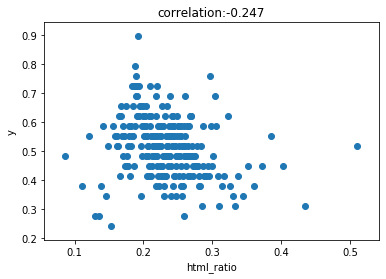

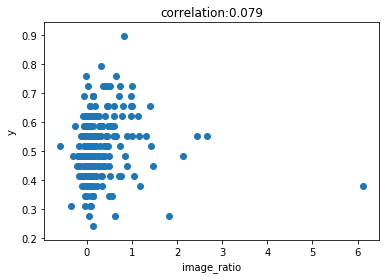

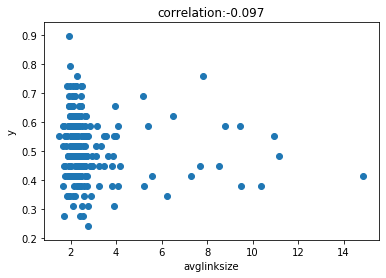

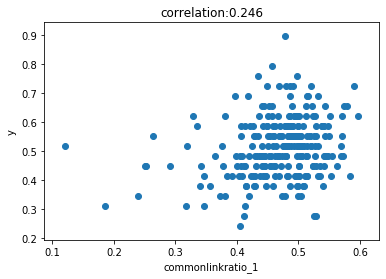

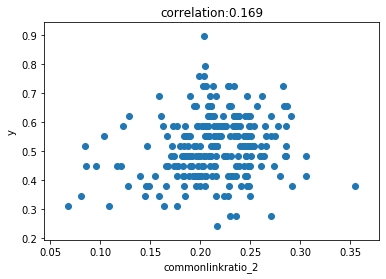

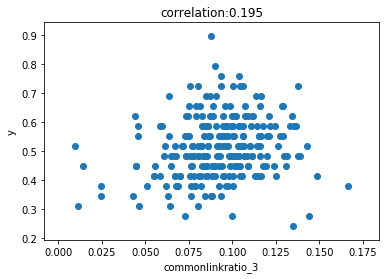

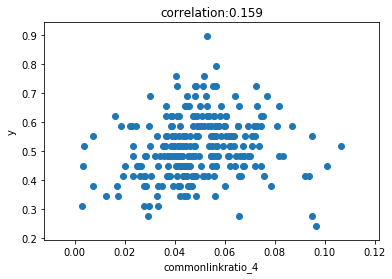

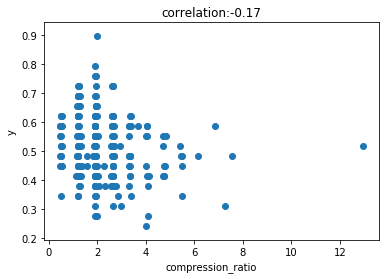

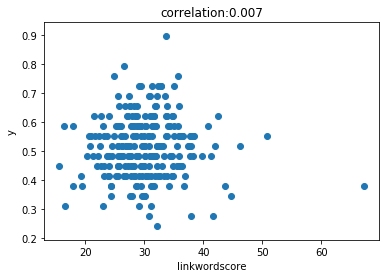

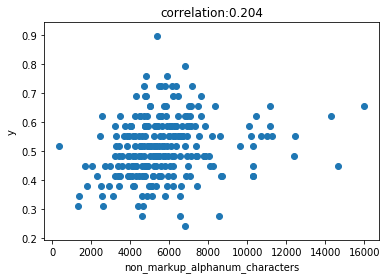

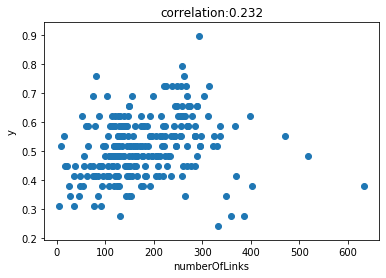

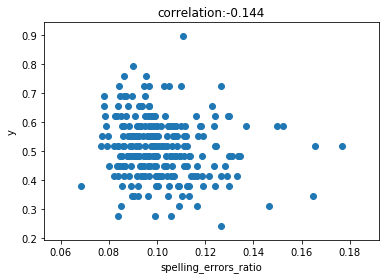

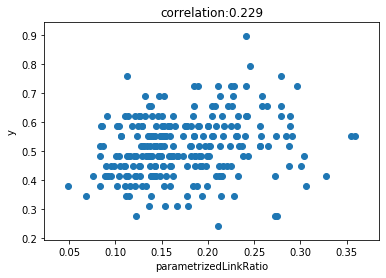

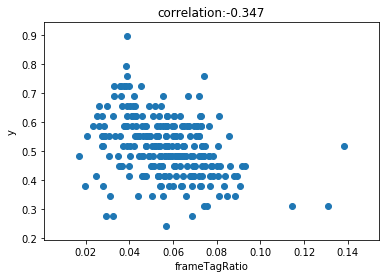

In [3]:
#### Bivariates - Numeric Variables ####
def plot_bivariate(variable):  
    sort_dat = raw_trn.sort_values('html_ratio')
    bkt = pd.Series(range(0,255)).repeat(29)
    sort_dat['bkt']=bkt.tolist()
    sort_dat_groupby_bkt= sort_dat.groupby('bkt')
    corr = np.corrcoef(sort_dat_groupby_bkt[variable].mean(),sort_dat_groupby_bkt['label'].mean())[0][1]
    fig,axs = plt.subplots()
    axs.scatter(sort_dat_groupby_bkt[variable].mean(),sort_dat_groupby_bkt['label'].mean())
    axs.set_xlabel(variable)
    axs.set_ylabel('y')
    axs.set_title("correlation:" + round(corr,3).astype(str) )

plot_bivariate('html_ratio')
plot_bivariate('image_ratio')
plot_bivariate('avglinksize')
plot_bivariate('commonlinkratio_1')
plot_bivariate('commonlinkratio_2')
plot_bivariate('commonlinkratio_3')
plot_bivariate('commonlinkratio_4')
plot_bivariate('compression_ratio')
plot_bivariate('linkwordscore')
plot_bivariate('non_markup_alphanum_characters')
plot_bivariate('numberOfLinks')
plot_bivariate('spelling_errors_ratio')
plot_bivariate('parametrizedLinkRatio')
plot_bivariate('frameTagRatio')




In [4]:
#### Contingency Tables for Categorical Variables ####
print(pd.crosstab(raw_trn.label, raw_trn.is_news))
print(pd.crosstab(raw_trn.label, raw_trn.lengthyLinkDomain))
print(pd.crosstab(raw_trn.label, raw_trn.news_front_page))
print(pd.crosstab(raw_trn.label, raw_trn.alchemy_category))

is_news     1     ?
label              
0        2199  1400
1        2353  1443
lengthyLinkDomain     0     1
label                        
0                  1280  2319
1                  1232  2564
news_front_page     0    1    ?
label                          
0                2814  156  629
1                3039  138  619
alchemy_category     ?  arts_entertainment  business  computer_internet  \
label                                                                     
0                 1166                 591       254                223   
1                 1176                 350       626                 73   

alchemy_category  culture_politics  gaming  health  law_crime  recreation  \
label                                                                       
0                              186      48     216         18         388   
1                              157      28     290         13         841   

alchemy_category  religion  science_technology  sports  unknow

In [5]:
##### Identify Missings ######
for i in range(0,len(raw_trn.columns)):
    num_miss = (raw_trn.iloc[:,i]=='?').sum()
    if num_miss>0:
        print(raw_trn.columns[i] + ' has '+str(num_miss) + ' missings')


C:\Users\peter\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


alchemy_category has 2342 missings
alchemy_category_score has 2342 missings
is_news has 2843 missings
news_front_page has 1248 missings


In [6]:
print(raw_trn.url.str.contains('.co.uk').value_counts())
print(raw_trn.url.str.contains('.com').value_counts())
print(raw_trn.url.str.contains('.org').value_counts())
print(raw_trn.url.str.contains('.net').value_counts())

#raw_trn.loc[raw_trn.url.str.contains('.com')==False,:].url.head(50)

False    7134
True      261
Name: url, dtype: int64
True     6367
False    1028
Name: url, dtype: int64
False    7092
True      303
Name: url, dtype: int64
False    6930
True      465
Name: url, dtype: int64


In [7]:
net = raw_trn.url.str.contains('.net').astype(int)
net

0       0
1       0
2       0
3       0
4       0
       ..
7390    0
7391    0
7392    0
7393    0
7394    0
Name: url, Length: 7395, dtype: int32

In [8]:
### Data Prep #####

def strip_url(var_to_strip):
    splitvar = var_to_strip.str.split('.com',expand = True)
    splitvar = splitvar.rename(columns = {0:'par0',1:'par1',2:'par2',3:'par3',4:'par4'})
    input1 = splitvar.par0.str.replace('http','')
    input2 = input1.str.replace('//','')
    input3 = input2.str.replace(':','')
    input4 = input3.str.replace('www','')
    input5 = input4.str.replace('.','')
    return(input5)

def one_hot_encode_with_na(dataset,variable,pref):
    dataset.loc[pd.isnull(dataset[variable])==True,variable] = "NA"
    temp = pd.get_dummies(dataset[variable],prefix = pref,drop_first = True)
    return(temp)

def data_prep(indata,dat_type):
    newdata =  indata.copy()
    newdata.loc[indata['alchemy_category']=='?','alchemy_category'] = 'Missing'
    newdata.loc[indata['alchemy_category_score']=='?','alchemy_category_score'] = 0
    newdata.loc[indata['is_news']=='?','is_news'] = 0
    newdata.loc[indata['news_front_page']=='?','news_front_page'] = 'Missing'
    newdata.loc[indata['news_front_page']=='0','news_front_page'] = 'N'
    newdata.loc[indata['news_front_page']=='1','news_front_page'] = 'Y'
    
    url_var = strip_url(raw_trn['url'])
    url_var[url_var.str.contains('news')] = 'news'
    top_urls = url_var.value_counts().to_frame().index[0:9]
    url_var[~url_var.isin(top_urls)] = 'random'
    url_var.value_counts()
    newdata['url_var'] = url_var
    
    couk = newdata.url.str.contains('.co.uk').astype(int).rename('couk')
    com = newdata.url.str.contains('.com').astype(int).rename('com')
    org = newdata.url.str.contains('.org').astype(int).rename('org')
    net = newdata.url.str.contains('.net').astype(int).rename('net')

    years = list((range(1990,2020)))
    contains_date=newdata.boilerplate.str.contains('|'.join(str(v) for v in years)).astype(int).rename('contains_date')
    
    num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric_columns = newdata.copy().select_dtypes(include=num_types)
    alchemy_category = one_hot_encode_with_na(newdata,"alchemy_category","alchemy_category")
    news_front_page = one_hot_encode_with_na(newdata,"news_front_page","news_fp")
    url_var = one_hot_encode_with_na(newdata,'url_var','url')
    if dat_type == 'trn':
        y = newdata['label']
        numeric_columns = numeric_columns.drop(['urlid','label'], axis = 1)
        final_dat = pd.concat([y,numeric_columns,alchemy_category,news_front_page,url_var,contains_date,
                              couk,com,org,net],axis = 1)

    else: 
        numeric_columns = numeric_columns.drop(['urlid'], axis = 1)
        final_dat = pd.concat([numeric_columns,alchemy_category,news_front_page,url_var,contains_date,
                              couk,com,org,net],axis = 1)
    return(final_dat)


In [9]:
clean_trn = data_prep(indata = raw_trn,dat_type = 'trn')
clean_tst = data_prep(indata = raw_tst,dat_type = 'tst')
clean_tst['alchemy_category_unknown']  =0
clean_tst['alchemy_category_weather']  =0

y_var = clean_trn['label']
X_vars = clean_trn.drop('label', axis = 1)
X_trn,X_hld,y_trn,y_hld = train_test_split(X_vars,y_var,test_size = 0.25,random_state = 123123)

In [10]:
clean_trn.head(7)

,label,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,lengthyLinkDomain,linkwordscore,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,alchemy_category_arts_entertainment,alchemy_category_business,alchemy_category_computer_internet,alchemy_category_culture_politics,alchemy_category_gaming,alchemy_category_health,alchemy_category_law_crime,alchemy_category_recreation,alchemy_category_religion,alchemy_category_science_technology,alchemy_category_sports,alchemy_category_unknown,alchemy_category_weather,news_fp_N,news_fp_Y,url_bleacherreport,url_blogsbabble,url_huffingtonpost,url_insidershealth,url_ivillage,url_news,url_random,url_sportsillustratedcnn,url_youtube,contains_date,couk,com,org,net
0,0,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1,24,5424,170,8,0.152941,0.079130,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
1,1,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0,0.098707,0,0.203490,0.088652,1,40,4973,187,9,0.181818,0.125448,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
2,1,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0,0.072448,0,0.226402,0.120536,1,55,2240,258,11,0.166667,0.057613,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
3,1,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,0,0.095861,0,0.265656,0.035343,0,24,2737,120,5,0.041667,0.100858,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
4,0,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,0,0.024908,0,0.228887,0.050473,1,14,12032,162,10,0.098765,0.082569,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
5,0,119.000000,0.745455,0.581818,0.290909,0.018182,0.434639,0.0,0,0.019841,0,0.298300,0.038636,0,12,4368,55,3,0.054545,0.087356,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
6,1,0.773810,0.215054,0.053763,0.043011,0.043011,0.579596,0.0,0,0.039568,0,0.218978,0.311377,0,21,1287,93,3,0.548387,0.064327,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [11]:
#### Simple Statsmodels #####
sm_vars = ['Intercept','commonlinkratio_1','commonlinkratio_2','commonlinkratio_3','commonlinkratio_4',
                         'numberOfLinks','lengthyLinkDomain','linkwordscore','numwords_in_url','spelling_errors_ratio',
                        'avglinksize','compression_ratio','hasDomainLink','html_ratio','image_ratio','news_fp_Y',
                        'non_markup_alphanum_characters']
Xtrn_sm = X_trn.assign(Intercept = 1)
Xhld_sm = X_hld.assign(Intercept = 1)
Xtrn_sm = Xtrn_sm.loc[:,sm_vars]
Xhld_sm = Xhld_sm.loc[:,sm_vars]

ydat = y_trn

ols = sm.OLS(ydat, Xtrn_sm)
ols_fit = ols.fit()
ols_fit.summary()
pred_hld=ols_fit.predict(Xhld_sm)

fpr, tpr, thresholds = metrics.roc_curve(y_hld, pred_hld, pos_label=1)
metrics.auc(fpr, tpr)

0.6594849156209839

### Grid Search

In [23]:
#### XGBOOST -- tracking results by parameter combination using a grid search ####
warnings.simplefilter(action='ignore', category=FutureWarning)
xgb_cv = XGBClassifier(n_estimators = 250, objective = 'binary:logistic',rnadom_state = 123123)

min_chi_w = []
max_dep =  []
learning_rt =   []
colsamp_bylev = []
colsamp_bytre =  []
reg_alpha =  []
gridxgb_trn_error = []
gridxgb_hld_error = []
for i in range(1,50):
    min_chi_w.append(int(randint.rvs(8,12,size = 1)))
    max_dep.append(int(randint.rvs(2,15,size = 1))) 
    learning_rt.append(float(uniform.rvs(0.01,0.025,size = 1)))
    colsamp_bylev.append(float(uniform.rvs(0.75,0.2,size = 1)))
    colsamp_bytre.append(float(uniform.rvs(0.75,0.2,size = 1)))
    reg_alpha.append(float(uniform.rvs(0.001,0.04,size = 1)))
    
    param_xgb_search = {'min_child_weight':[min_chi_w[i-1]],
                        'max_depth': [max_dep[i-1]],
                        'learning_rate': [learning_rt[i-1]],
                        'colsample_bylevel': [colsamp_bylev[i-1]],
                        'colsample_bytree': [colsamp_bytre[i-1]],
                        'reg_alpha': [reg_alpha[i-1]]    
    }
    grid_search_xgb = GridSearchCV(xgb_cv,
                                          param_grid = param_xgb_search,
                                          cv = 5,
                                          scoring = 'roc_auc',
                                          refit = True)
    grid_search_xgb.fit(X_trn,y_trn, eval_metric = 'auc',
                          eval_set = [(X_hld,y_hld)],
                          early_stopping_rounds = 10,
                          verbose = 0)
    
    ##Training Error
    grid_xgb_bestmdl_pred_trn = pd.Series(grid_search_xgb.predict_proba(X_trn)[:,1],index = y_trn.index)
    error_gridxgb_trn = pd.concat([y_trn,grid_xgb_bestmdl_pred_trn],axis = 1)
    error_gridxgb_trn = error_gridxgb_trn.rename(columns = {'label':'actual',0:'prediction'})
    fpr, tpr, thresholds = metrics.roc_curve(error_gridxgb_trn.actual, error_gridxgb_trn.prediction, pos_label=1)
    gridxgb_trn_error.append(metrics.auc(fpr, tpr))
    #print(metrics.auc(fpr, tpr))

    ##Holdout Error
    grid_xgb_bestmdl_pred_hld = pd.Series(grid_search_xgb.predict_proba(X_hld)[:,1],index = y_hld.index)
    error_gridxgb_hld = pd.concat([y_hld,grid_xgb_bestmdl_pred_hld],axis = 1)
    error_gridxgb_hld = error_gridxgb_hld.rename(columns = {'label':'actual',0:'prediction'})
    fpr, tpr, thresholds = metrics.roc_curve(error_gridxgb_hld.actual, error_gridxgb_hld.prediction, pos_label=1)
    #print(metrics.auc(fpr, tpr))
    gridxgb_hld_error.append(metrics.auc(fpr, tpr))

### Check Metrics vs Parameters ####
metrics_to_plot = pd.concat([pd.Series(min_chi_w),
           pd.Series(max_dep),
           pd.Series(learning_rt),
           pd.Series(colsamp_bylev),
           pd.Series(colsamp_bytre),
           pd.Series(reg_alpha),
           pd.Series(gridxgb_trn_error),
           pd.Series(gridxgb_hld_error)
          ],axis = 1)
metrics_to_plot = metrics_to_plot.rename(columns = {0:'Min_Child_Wgt',
                          1:'Max_Depth',
                          2:'Learning_Rate',
                          3:'Col_Samp_bylev',
                          4:'Col_Samp_bytre',
                          5:'reg_alpha',
                          6:'trn_error',
                          7:'hld_error' })

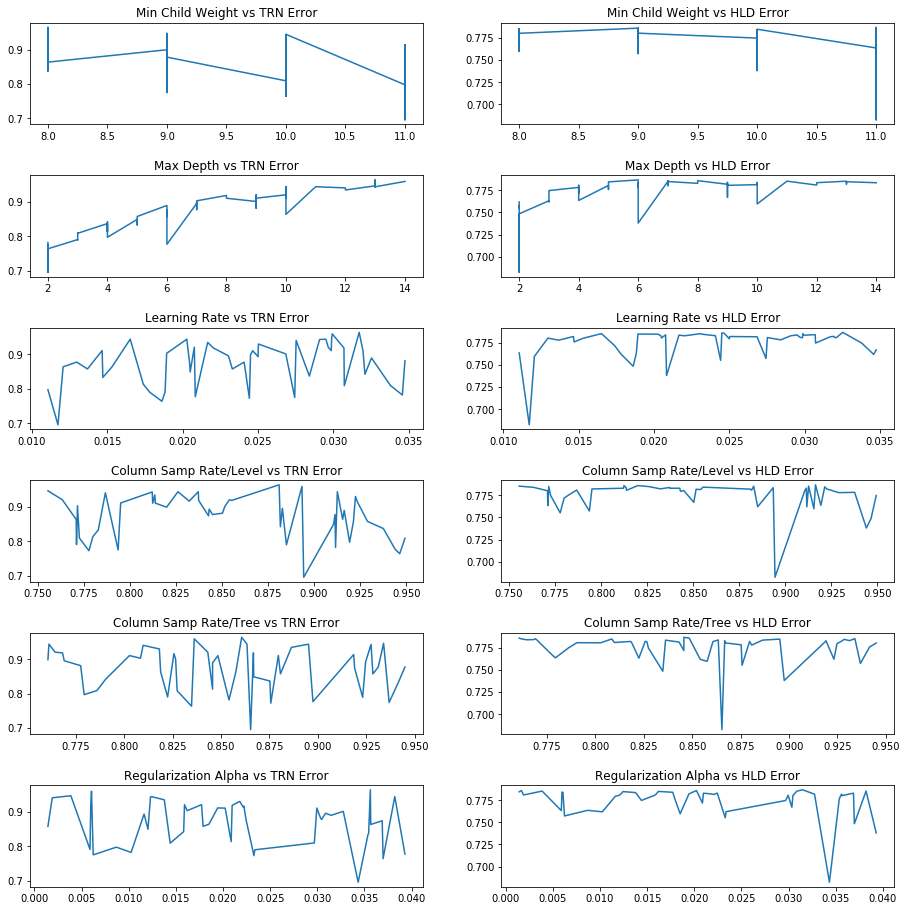

In [24]:
##### Plot metrics_to_plot vs Parameter (sorted) ####
fig,axs=plt.subplots(6,2)
axs[0,0].plot(metrics_to_plot.sort_values('Min_Child_Wgt').Min_Child_Wgt,metrics_to_plot.sort_values('Min_Child_Wgt').trn_error)
axs[0,0].set_title('Min Child Weight vs TRN Error' )
axs[1,0].plot(metrics_to_plot.sort_values('Max_Depth').Max_Depth,metrics_to_plot.sort_values('Max_Depth').trn_error)
axs[1,0].set_title('Max Depth vs TRN Error' )
axs[2,0].plot(metrics_to_plot.sort_values('Learning_Rate').Learning_Rate,metrics_to_plot.sort_values('Learning_Rate').trn_error)
axs[2,0].set_title('Learning Rate vs TRN Error' )
axs[3,0].plot(metrics_to_plot.sort_values('Col_Samp_bylev').Col_Samp_bylev,metrics_to_plot.sort_values('Col_Samp_bylev').trn_error)
axs[3,0].set_title('Column Samp Rate/Level vs TRN Error' )
axs[4,0].plot(metrics_to_plot.sort_values('Col_Samp_bytre').Col_Samp_bytre,metrics_to_plot.sort_values('Col_Samp_bytre').trn_error)
axs[4,0].set_title('Column Samp Rate/Tree vs TRN Error' )
axs[5,0].plot(metrics_to_plot.sort_values('reg_alpha').reg_alpha,metrics_to_plot.sort_values('reg_alpha').trn_error)
axs[5,0].set_title('Regularization Alpha vs TRN Error' )


axs[0,1].plot(metrics_to_plot.sort_values('Min_Child_Wgt').Min_Child_Wgt,metrics_to_plot.sort_values('Min_Child_Wgt').hld_error)
axs[0,1].set_title('Min Child Weight vs HLD Error' )
axs[1,1].plot(metrics_to_plot.sort_values('Max_Depth').Max_Depth,metrics_to_plot.sort_values('Max_Depth').hld_error)
axs[1,1].set_title('Max Depth vs HLD Error' )
axs[2,1].plot(metrics_to_plot.sort_values('Learning_Rate').Learning_Rate,metrics_to_plot.sort_values('Learning_Rate').hld_error)
axs[2,1].set_title('Learning Rate vs HLD Error' )
axs[3,1].plot(metrics_to_plot.sort_values('Col_Samp_bylev').Col_Samp_bylev,metrics_to_plot.sort_values('Col_Samp_bylev').hld_error)
axs[3,1].set_title('Column Samp Rate/Level vs HLD Error' )
axs[4,1].plot(metrics_to_plot.sort_values('Col_Samp_bytre').Col_Samp_bytre,metrics_to_plot.sort_values('Col_Samp_bytre').hld_error)
axs[4,1].set_title('Column Samp Rate/Tree vs HLD Error' )
axs[5,1].plot(metrics_to_plot.sort_values('reg_alpha').reg_alpha,metrics_to_plot.sort_values('reg_alpha').hld_error)
axs[5,1].set_title('Regularization Alpha vs HLD Error' )

plt.subplots_adjust(bottom=0, left = 0,right=2, top=3,hspace = 0.5 )


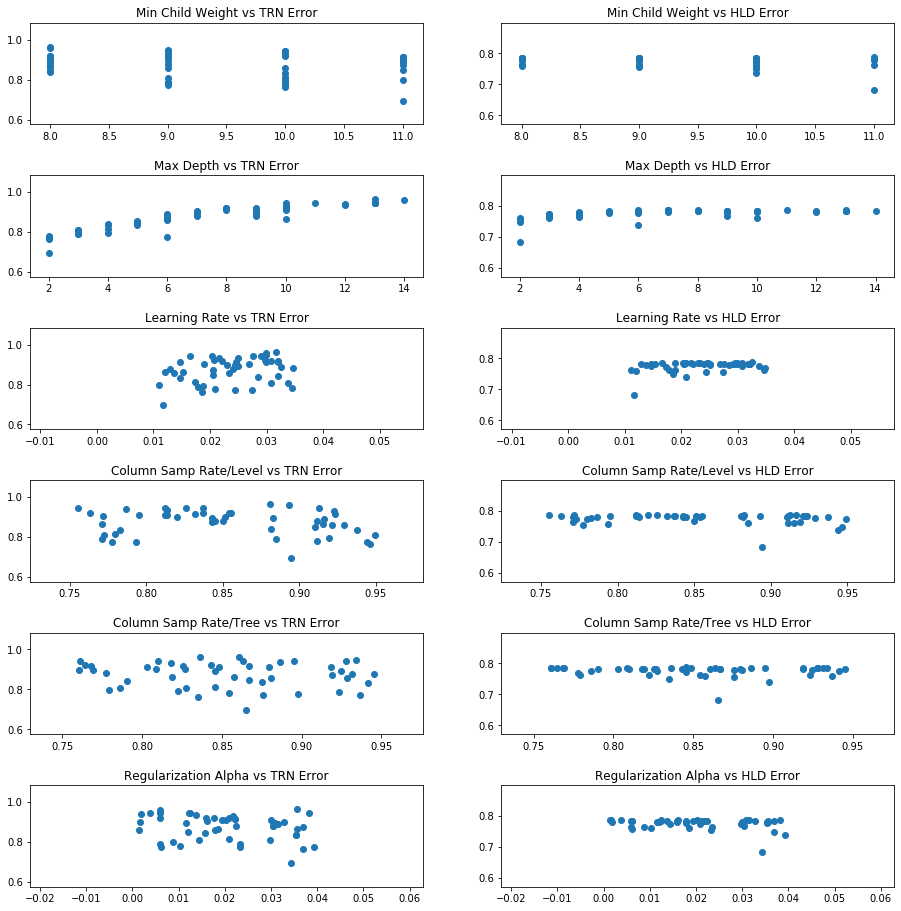

In [25]:
##### Plot metrics_to_plot vs Parameter (unsorted) ####
fig,axs=plt.subplots(6,2)
axs[0,0].scatter(metrics_to_plot.Min_Child_Wgt,metrics_to_plot.trn_error)
axs[0,0].set_title('Min Child Weight vs TRN Error' )
axs[1,0].scatter(metrics_to_plot.Max_Depth,metrics_to_plot.trn_error)
axs[1,0].set_title('Max Depth vs TRN Error' )
axs[2,0].scatter(metrics_to_plot.Learning_Rate,metrics_to_plot.trn_error)
axs[2,0].set_title('Learning Rate vs TRN Error' )
axs[3,0].scatter(metrics_to_plot.Col_Samp_bylev,metrics_to_plot.trn_error)
axs[3,0].set_title('Column Samp Rate/Level vs TRN Error' )
axs[4,0].scatter(metrics_to_plot.Col_Samp_bytre,metrics_to_plot.trn_error)
axs[4,0].set_title('Column Samp Rate/Tree vs TRN Error' )
axs[5,0].scatter(metrics_to_plot.reg_alpha,metrics_to_plot.trn_error)
axs[5,0].set_title('Regularization Alpha vs TRN Error' )


axs[0,1].scatter(metrics_to_plot.Min_Child_Wgt,metrics_to_plot.hld_error)
axs[0,1].set_title('Min Child Weight vs HLD Error' )
axs[1,1].scatter(metrics_to_plot.Max_Depth,metrics_to_plot.hld_error)
axs[1,1].set_title('Max Depth vs HLD Error' )
axs[2,1].scatter(metrics_to_plot.Learning_Rate,metrics_to_plot.hld_error)
axs[2,1].set_title('Learning Rate vs HLD Error' )
axs[3,1].scatter(metrics_to_plot.Col_Samp_bylev,metrics_to_plot.hld_error)
axs[3,1].set_title('Column Samp Rate/Level vs HLD Error' )
axs[4,1].scatter(metrics_to_plot.Col_Samp_bytre,metrics_to_plot.hld_error)
axs[4,1].set_title('Column Samp Rate/Tree vs HLD Error' )
axs[5,1].scatter(metrics_to_plot.reg_alpha,metrics_to_plot.hld_error)
axs[5,1].set_title('Regularization Alpha vs HLD Error' )

plt.subplots_adjust(bottom=0, left = 0,right=2, top=3,hspace = 0.5 )

In [26]:
metrics_to_plot.sort_values('hld_error')

,Min_Child_Wgt,Max_Depth,Learning_Rate,Col_Samp_bylev,Col_Samp_bytre,reg_alpha,trn_error,hld_error
42,11,2,0.011724,0.894379,0.865309,0.034337,0.695217,0.682454
37,10,6,0.020839,0.944007,0.897503,0.039301,0.776936,0.738014
29,10,2,0.018625,0.946515,0.834779,0.036982,0.763751,0.748439
33,10,2,0.024431,0.777735,0.875713,0.023284,0.772509,0.755129
23,9,2,0.027441,0.793590,0.936862,0.006229,0.774797,0.757182
1,8,10,0.012067,0.915527,0.857681,0.018502,0.863962,0.759627
32,9,2,0.034588,0.911672,0.854122,0.010248,0.781923,0.761856
44,9,3,0.017826,0.884988,0.923181,0.023373,0.789568,0.762018
30,10,3,0.018833,0.770996,0.822416,0.005890,0.790524,0.763185
18,11,4,0.011058,0.919303,0.779301,0.008687,0.797282,0.763527


### Random Search in the Area that looked best based on Grid Search

In [32]:
#### XGBOOST -- Random Parameter search ####
#n_estimators = number of trees
#n_iter = number of parameter combinations to check

warnings.simplefilter(action='ignore', category=FutureWarning)
xgb_cv = XGBClassifier(n_estimators = 300, objective = 'binary:logistic',rnadom_state = 123123)
param_xgb_search = {'min_child_weight':randint(8,4),
                    'max_depth': randint(6,4),
                    'learning_rate': uniform(0.005,0.02),
                    'colsample_bylevel': uniform(0.75,0.2),
                    'colsample_bytree': uniform(0.75,0.2),
                    'reg_alpha': uniform(0.005,0.01)    
}
random_search_xgb = RandomizedSearchCV(xgb_cv,
                                      param_distributions = param_xgb_search,
                                      n_iter = 5,
                                      cv = 5,
                                      scoring = 'roc_auc',
                                      random_state = 1231,
                                      refit = True)
random_search_xgb.fit(X_trn,y_trn, eval_metric = 'auc',
                      eval_set = [(X_hld,y_hld)],
                      early_stopping_rounds = 10,
                      verbose = 0)

ValueError: Domain error in arguments.

In [28]:
print(random_search_xgb.best_estimator_)

##Training Error
xgb_bestmdl_pred_trn = pd.Series(random_search_xgb.predict_proba(X_trn)[:,1],index = y_trn.index)
error_xgb_trn = pd.concat([y_trn,xgb_bestmdl_pred_trn],axis = 1)
error_xgb_trn = error_xgb_trn.rename(columns = {'label':'actual',0:'prediction'})
fpr, tpr, thresholds = metrics.roc_curve(error_xgb_trn.actual, error_xgb_trn.prediction, pos_label=1)
print(metrics.auc(fpr, tpr))

##Holdout Error
xgb_bestmdl_pred_hld = pd.Series(random_search_xgb.predict_proba(X_hld)[:,1],index = y_hld.index)
error_xgb_hld = pd.concat([y_hld,xgb_bestmdl_pred_hld],axis = 1)
error_xgb_hld = error_xgb_hld.rename(columns = {'label':'actual',0:'prediction'})
fpr, tpr, thresholds = metrics.roc_curve(error_xgb_hld.actual, error_xgb_hld.prediction, pos_label=1)
print(metrics.auc(fpr, tpr))

##Create Test
col_order = X_hld.columns.tolist()
clean_tst = clean_tst[col_order]
xgb_bestmdl_pred_tst = pd.Series(random_search_xgb.predict_proba(clean_tst)[:,1])
out_tst = pd.concat([raw_tst.urlid,xgb_bestmdl_pred_tst],axis = 1)
out_tst = out_tst.rename(columns = {'urlid':'urlid',0:"label"})
out_tst.to_csv('test_file_v5.csv',sep = ',')

plot_importance(random_search_xgb.best_estimator_,max_num_features = 7)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'